# Canadian cancer statistics: a mixed story

I recently [reviewed](https://bioeconometrician.github.io/first_cell/) Azra Raza's new book *The First Cell*, whose primary thesis is that cancer research has failed to translate into effective treatments due to a combination or poor incentives and a flawed experimental paradigm. The book's focus was on the American healthcare system and made few international comparisons. This piqued my curiosity as to the . The cancer that Dr. Raza treats, myelodysplastic syndromes (MDS) and its evolutionary successor, malignancy acute myeloid leukemia (AML), are one of the cancer types that have seen almost no improvement in therapeutic options in the last 30 years. Despite the hype about "blockbuster" therapies being "game changers", the "immunotherapy revolution" has been remarkably unimpressive, with overall gains usually measured in [months](https://jamanetwork.com/journals/jamaotolaryngology/article-abstract/1891387). This is hardly surprising given that only [5% of cancer drugs](https://tinyurl.com/y2n8rnzb) even reach the market. 

Oncologists will anecdotally tell you that the number of cancer patients in almost every specialty is rising each year. But the main reason for the phenomena is almost surely the rapidly aging population. I set out to answer three questions:

1. How has Canadian cancer mortality changed over time?
2. How many cancer deaths are attributable to Canada's aging population?
3. Are we getting better at treating cancer in Canada?

I CAN'T KNOW HOW MUCH IS BECAUSE OF NEW DRUGS, BUT DECLINING AGE-ADJUSTED MORTALITY RATES SHOULD BE USED
ALSO, I DO NOT FOCUS OF 5-YEAR SURVIVAL RATES BECAUSE THEY CAN BE MISLEADING: LEAD-TIME BIAS DUE TO SCREENING. CANCER DEATHS ARE AT LEAST MUCH EASIER TO QUANTIFY.[[^1]]
IN TERMS OF COST PLANNING, THIS ANALYSIS IS USELESS, WE NEED TO BUDGET FOR THIS LINEAR INCREASE BUT I'M MORE INTERESTED IN "ARE WE GETTING BETTER"

KEY TAKE AWAYS

1. Canada's aging population accounts for the increase in aggregate and per capita cancer death rates
2. Age-specific cancer death rates are falling for all groups, except for the 85+ which are stable
3. Holding constant Canada's population structure, overall cancer deaths would be declining over time
4. Mortality rates for the six deadliest cancers, as measured by per capita deaths, has been declining over time after adjusting for population structure (e.g. breast, lung, GI, and prostate)
5. Mortality rate for eight other cancer types has shown no improvement (e.g. bone, melanoma, thyroid, and CNS)


[^1]: Determining the cause of death is not always easy however. There is certainly some error in this calculation. Furthermore, since most people that die of cancer are elderly, and elderly patients tend to have comorbidities, it is difficult to disentangle what pathology actually killed a patient. Despite these caveats, the cause of death is still more reliable and consistent across years than other measurements. 

## (1) Data sources

To calculate the number of deaths I used deaths by *Malignant neoplasms* from StatsCan [table 13-10-0394-01](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1310039401): *Leading causes of death, total population, by age group*. Cancer makes up the plurality of deaths of annual deaths in Canada (30%), followed by heart disease. This table can be further decomposed into the type of neoplasm with [table 13-10-0142-01](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1310014201): *Deaths, by cause, Chapter II: Neoplasms*, to break down ICD-10 cause of death codes C00-C97. To make the number of deaths comparable between years, cancer deaths are normalized by the population (per 100K persons) using StatsCan [table 17-10-0005-01](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000501). Note that a copy of the `csv` files in the analysis below can be found [here](https://github.com/erikdrysdale/erikdrysdale.github.io/tree/master/_rmd/extra_cancer). 

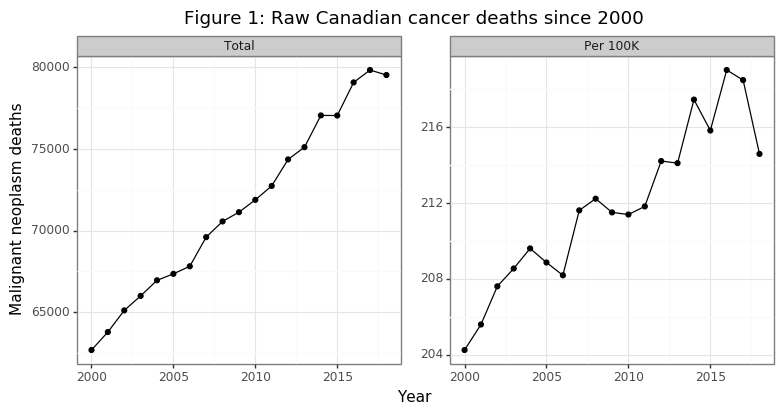

<ggplot: (8790170861101)>

In [1]:
import os
import pandas as pd
import numpy as np
import plotnine
from plotnine import *
from matplotlib import cm, colors
from plydata.cat_tools import *

# Load the CSV files
df_cancer = pd.read_csv('1310039401.csv',usecols=['year','number'])
df_cancer.rename(columns={'year':'years','number':'cancer'}, inplace=True)
df_pop = pd.read_csv('1710000501.csv')
df_pop = df_pop.melt('years',None,'grp','population')
# Raw rate per 100K
df_pop_total = df_pop.query('grp=="All ages"').drop(columns='grp').rename(columns={'population':'total'})
df_rate = df_pop_total.merge(df_cancer,how='right',on='years').assign(rate=lambda x: x.cancer/(x.total/100000))
# plot
tmp = df_rate.melt('years',['cancer','rate'],'tt')
tmp.head()
plotnine.options.figure_size = (9, 4)
gg_agg = (ggplot(tmp,aes(x='years',y='value')) + theme_bw() + 
          geom_point() + geom_line() + 
          facet_wrap('~tt',scales='free_y',labeller=labeller(tt={'cancer':'Total','rate':'Per 100K'})) + 
          labs(y='Malignant neoplasm deaths', x='Year') + 
          ggtitle('Figure 1: Raw Canadian cancer deaths since 2000') + 
          theme(subplots_adjust={'wspace': 0.15}))
gg_agg

Figure 1 shows that the number of annual cancer deaths has been rising with a linear trend from 2000 to 2018. A staggering 1.36 million Canadians have died of cancer in this time frame. The second panel in the figure also shows that the death rate per capita has also been increasing, although in a less smooth fashion. Overall per capita death rates are about 4% higher in 2018 then they were in 2000. These data are not encouraging. However, it is important to remember that these plots do not take into account the change in the composition of the Canadian population (i.e. our society is aging). As Raza points out in her book, the cancer's that emerge in older populations are much more genetically complex due to a higher mutational load. Successful treatments are therefore likely to be, at best, temporary since the cancer cells that survive will now resistant to the treatment, and there is more variations in cells for natural selection to occur over.

## (2) Adjusting for age

The goal of this section is to estimate how many people would have died of cancer had the population structure of Canada stayed the same. Even if age-specific cancer mortality rates are declining for all population groups, cancer deaths per capita can still rise if the decline in mortality is offset by a high share of the population going into the higher death rate age groups. One challenge when dealing with publicly available census data is that the age categories are usually aggregated. The data discussed in section (1) uses 10-year age ranges (e.g. 45-54) for age categories. One [subtle effect](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4763761/) of an aging population may be to change the distribution within these age bins (e.g. more 54 compared to 45 year olds over time). I do not, and cannot account for this. However, the bias of this confounder will be to understate declines in age-specific deaths if the population is generally aging. As will soon be made clear, I show age-adjusted declines in mortality, so this bias would not change the sign the interpretation.

Two statistical facts drive the increase in per capita cancer deaths in Canada, as Figure 2A shows below:

1. The Canadian population is aging
2. Older Canadians are more likely to die of cancer

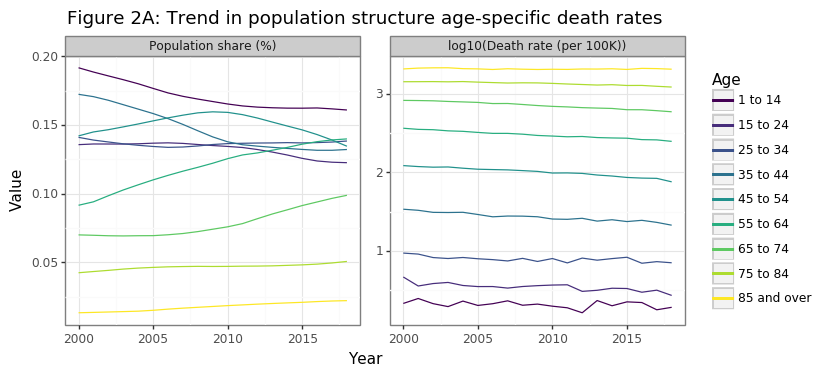

<ggplot: (8790162333317)>


In [2]:
# Age-specific cancer
df_age = pd.read_csv('1310039401_by_age.csv')
df_age.age = df_age.age.str.split('\\,\\s',expand=True).iloc[:,1]
df_age.age = df_age.age.fillna(method='ffill')
df_age.age = df_age.age.str.replace('\\syears','')
# Age-specific population
di_age = {'0 to 4':'1 to 14', '5 to 9':'1 to 14', '10 to 14':'1 to 14',
          '15 to 19':'15 to 24', '20 to 24':'15 to 24',
          '25 to 29':'25 to 34', '30 to 34':'25 to 34',
          '35 to 39':'35 to 44', '40 to 44':'35 to 44',
          '45 to 49':'45 to 54', '50 to 54':'45 to 54',
          '55 to 59':'55 to 64', '60 to 64':'55 to 64',
          '65 to 69':'65 to 74', '70 to 74':'65 to 74',
          '75 to 79':'75 to 84', '80 to 84':'75 to 84',
          '85 to 89':'85 and over','90 to 94':'85 and over',
          '95 to 99':'85 and over', '100 and over':'85 and over',
          'Under 1 year':'1 to 14', '1 to 4':'1 to 14', '90 and over':'85 and over'}
df_pop_sub = df_pop.query('grp!="All ages"').assign(grp=lambda x: x.grp.str.replace('\\syears',''))
df_pop_sub = df_pop_sub.assign(age=lambda x: x.grp.map(di_age)).groupby(['years','age']).population.sum().reset_index()
# Merge
df_age = df_pop_sub.merge(df_age,how='right',on=['years','age'])
df_age = df_age.assign(rate=lambda x: x.number/(x.population/1e5))
df_age = df_age.merge(df_pop_total,'left','years').assign(pop_share=lambda x: x.population / x.total)
tmp = df_age.assign(rate=lambda x: np.log10(x.rate)).melt(['years','age'],['pop_share','rate'],'tt')
# Repeat for index
tmp2 = tmp.groupby(['age','tt']).head(1).drop(columns='years').rename(columns={'value':'bl'})
tmp = tmp.merge(tmp2, 'left', ['age','tt']).assign(idx=lambda x: x.value/x.bl*100)

lblz = list(tmp.age.unique())
n_age = len(lblz)
mat = cm.get_cmap('viridis',n_age).colors
colz = []
for ii in range(n_age):
  colz.append(colors.to_hex(mat[ii]))
plotnine.options.figure_size = (8, 3.5)
di_age_rate = {'pop_share':'Population share (%)', 'rate':'log10(Death rate (per 100K))'}
gg_age_rate = (ggplot(tmp, aes(x='years',y='value',color='age',group='age')) + theme_bw() + 
               geom_line() + labs(y='Value',x='Year') + 
               facet_wrap('~tt',scales='free_y',labeller=labeller(tt=di_age_rate)) + 
               theme(subplots_adjust={'wspace':0.1}) + 
               scale_color_manual(name='Age',values=colz,labels=lblz) + 
               ggtitle("Figure 2A: Trend in population structure age-specific death rates"))
print(gg_age_rate)

Figure 2A shows that Canadian population has slowly been aging over the last 20 years. The changes have been modest but sustained. From 2000 to 2018 the share of population >55 years old increased from 22% to 31%, and the equivalent figure for 65+ was 12 to 17%. The second panel in Figure 2A shows why, from the perspective of overall cancer death rates, this affect have tremendous consequences for death rates. The cancer death rate grows exponentially by age category. This is why 85+ year olds are a 1000 times more likely than children (1-14) to die of cancer. Every decade increase effectively doubles or triples the age-specific cancer risk. Hence a 75-84 year old is four times more likely than a 55-64 to develop cancer.

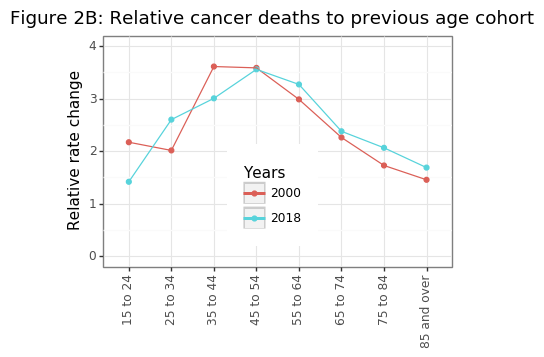

<ggplot: (8790162220081)>

In [3]:
tmp3 = df_age[df_age.years.isin([2000,2018])].sort_values(['years','age'])
tmp3 = tmp3.assign(rate_d=lambda x: x.rate/x.groupby('years').rate.shift(1))
tmp3 = tmp3[tmp3.rate_d.notnull()].assign(years=lambda x: pd.Categorical(x.years))
plotnine.options.figure_size = (4.5, 3)
gg_rate_delta = (ggplot(tmp3, aes(x='age',y='rate_d',color='years',group='years')) + theme_bw() + 
                 geom_point() + geom_line() + 
                 ggtitle('Figure 2B: Relative cancer deaths to previous age cohort') + 
                 theme(axis_title_x=element_blank(), axis_text_x=element_text(angle=90),
                      legend_position=(0.5,0.35)) + 
                 labs(y='Relative rate change') + 
                 scale_y_continuous(limits=[0,4],breaks=list(np.arange(0,5,1))) + 
                 scale_color_discrete(name='Years'))
gg_rate_delta

Figure 2B shows that exponential trend is age-specific mortality rates has been fairly constant over 20 years suggesting that the increases in cancer risk are biological. Environmental factors may also be present (e.g. lung cancer takes decades to kill you), but they are likely consistent across time too. To make the trends more clear from Figure 2A, it is useful to index the population shares and age-specific cancer mortality rates to the year 2000.

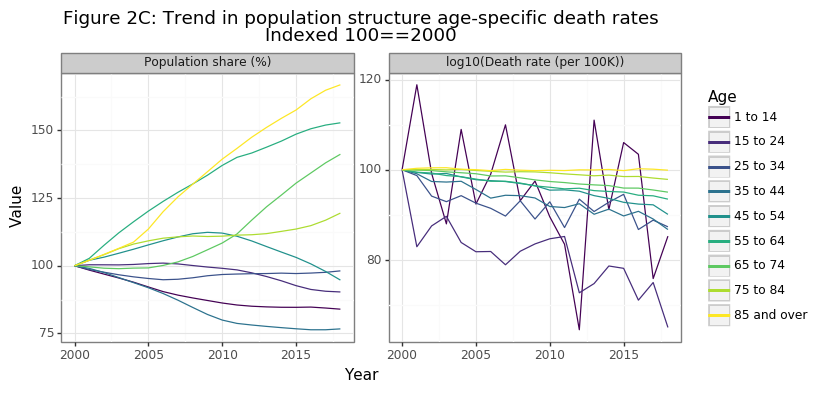

<ggplot: (8790160591805)>


In [4]:
plotnine.options.figure_size = (8, 3.5)
gg_age_rate_idx = (ggplot(tmp, aes(x='years',y='idx',color='age',group='age')) + theme_bw() + 
               geom_line() + labs(y='Value',x='Year') + 
               facet_wrap('~tt',scales='free_y',labeller=labeller(tt=di_age_rate)) + 
               theme(subplots_adjust={'wspace':0.12}) + 
               scale_color_manual(name='Age',values=colz,labels=lblz) + 
               ggtitle("Figure 2C: Trend in population structure age-specific death rates\nIndexed 100==2000"))
print(gg_age_rate_idx)

Figure 2C shows that the biggest relative gain in the population share have occurred for the  65-74, 75-84, and 85+ age categories, with the latter increasing by more than 60% in 20 years. Because cancer deaths in the 85+ age range are extremely high, a trend of the population structure towards this age demographic will drastically increase overall cancer death numbers. As a final figure lets see the aggregate mortality broken down by age.

The second figure in 2C is the more promising: age-specific cancer death rates have declined in a consistent manner for every age group since 2000. While the relative decline has been a modest 5% for 65-74 year olds, it has been an impressive 35% reduction for those aged 15-24. This finding was the most surprising result of this analysis, and gives definitive evidence that we are getting better at preventing people from dying from cancer. I will discuss this further in the conclusion.

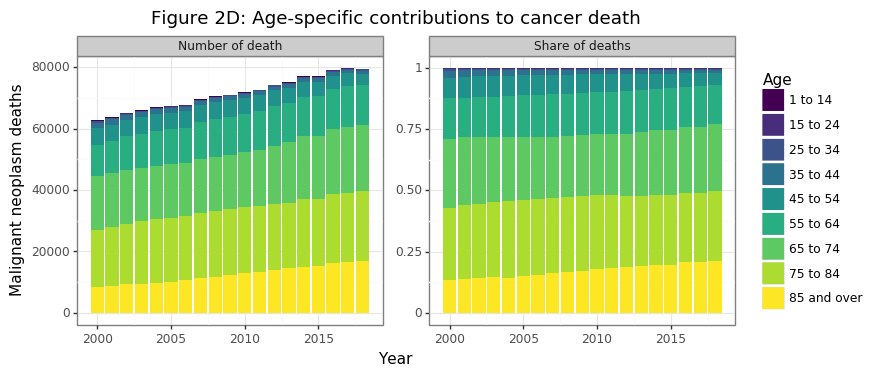

<ggplot: (8790162219005)>

In [5]:
tmp4 = df_age.merge(df_cancer,'left','years').assign(share = lambda x: x.number/x.cancer)
tmp4 = tmp4.melt(['years','age'],['number','share'],'tt')

plotnine.options.figure_size = (8.5, 3.5)
di_tt = {'number':'Number of death','share':'Share of deaths'}
gg_age_breakdown = (ggplot(tmp4, aes(x='years',weight='value',fill='age')) + theme_bw() + 
                    labs(y='Malignant neoplasm deaths', x='Year') + 
                    geom_bar() + facet_wrap('~tt',scales='free_y',labeller=labeller(tt=di_tt)) + 
                    ggtitle('Figure 2D: Age-specific contributions to cancer death') + 
                    scale_fill_manual(name='Age',values=colz,labels=lblz) + 
                    theme(subplots_adjust={'wspace': 0.15}))
gg_age_breakdown

In [29]:
# tmp4.query('tt=="share"').pivot('age','years','value')[[2000,2018]].assign(dd=lambda x: x[2018]/x[2000])

Figure 4 shows that half and three-quarters of all cancer deaths today come from those over the age of 75 and 65, respectively. Cancer deaths for those less than 55 made up only 7% of the total share in 2018. Cancer is overwhelmingly an killer of the elderly and retired. So far the data has shown that:

1. The Canadian population is slowly greying (Figure 2A)
2. Cancer becomes exponentially more dangerous every year of aging (Figure 2B)
3. Age-specific mortality has declined for every category except those of 85+, where it has remained stable (Figure 2C)
4. Cancer deaths are growing in aggregate and per capita number because the share of 85+ cancer deaths has increased, the 55-84 has remained constant, and the <55 has declined (Figure 2D)

No we are at a point where we can try to estimate the counterfactual number of cancer deaths by holding the population structure the same. Because age-specific mortality rates have gotten better (or at least no worse) for all age ranges (Figure 2C), this adjusted measure will necessarily show a decline. The notation used in the formula below is as follows.  The age category and year are denoted by $i$ and $t$, respectively. The population and cancer deaths are referred to as $p$ and $c$ respectively. The age-specific death rate from cancer id $d_{i,t}$ and the overall Canadian population growth is $g_t$.

$$
\begin{align*}
g_t &= p_t / p_{t_1} \\
d_{i,t} &= c_{i,t} / p_{i,t} \\
\tilde p_{i,t} &= \tilde p_{i,t-1} \cdot g_t \\
\tilde c_{i,t} &= \tilde p_{i,t} \cdot d_{i,t}
\end{align*}
$$

The formula above show that in order to get the counterfactual cancer death numbers, \\(\tilde c_{i,t}\\), the actual cancer death rate for that age cohort (as measured in the data), is multiplied by a population cohort that grows at the overall Canadian population rate, rather that its true age-specific growth rates. This ensures that the total counterfactual Canadian population remains identical in any year, but that its relative population shares remain unchanged since the year 2000. 


/home/edrysdale/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


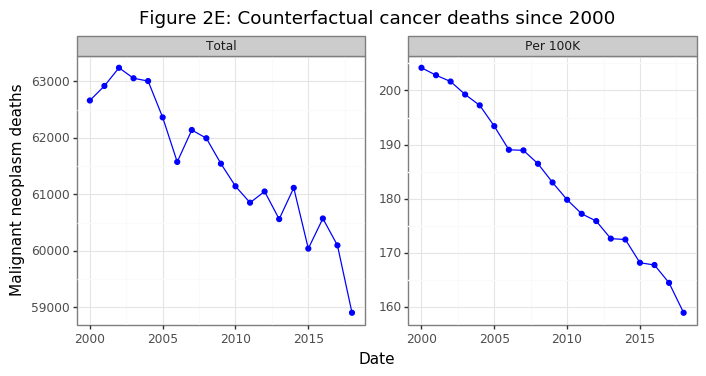

<ggplot: (8790160583841)>

In [33]:
df_pop_r = df_pop_total.assign(r=lambda x: x.total/x.total.head(1).values).drop(columns='total')
df_idx = df_age.assign(population=lambda x: np.where(x.years==x.years.head(1).values[0],x.population,np.NaN)).drop(columns='number')
df_idx.population = df_idx.groupby('age').population.fillna(method='ffill')
df_idx = df_idx.merge(df_pop_r,'left','years').assign(population=lambda x: x.population*x.r)
df_idx = df_idx.assign(cancer=lambda x: x.rate*(x.population/1e5))
df_idx = df_idx.groupby('years')['population','cancer'].sum().astype(int).reset_index()
df_idx = df_idx.assign(rate=lambda x: x.cancer/(x.population/1e5))

tmp3 = df_idx.melt('years',['cancer','rate'],'tt')
plotnine.options.figure_size = (8, 3.5)
gg_theory = (ggplot(tmp3,aes(x='years',y='value')) + theme_bw() + 
          geom_point(color='blue') + geom_line(color='blue') + 
          facet_wrap('~tt',scales='free_y',labeller=labeller(tt={'cancer':'Total','rate':'Per 100K'})) + 
          labs(y='Malignant neoplasm deaths', x='Date') + 
          ggtitle('Figure 2E: Counterfactual cancer deaths since 2000') + 
          theme(subplots_adjust={'wspace': 0.15}))
gg_theory

In [39]:
# df_idx[df_idx.years.isin([2000,2018])]/df_idx[df_idx.years.isin([2000,2018])].shift(1)-1

Had the population structure remained the same in Canada, the aggregate number of Cancer deaths would have declined by 6%, despite the overall population increasing by 21%. On a per capita basis this amount to a 22% decrease in age-consistent death rates. What is most impressive about Figure 2E is that the decline in population structure consistent per capita death rates is that they have been falling at a linear rate. Were this trend to continue, it would mean very few Canadians below the age of retirement would be dying from cancer.

## (3) Cancer-specific trends

Section (2) has shown without a doubt that age factors are the key to understanding Canada's cancer statistics. Our rapidly aging population is causing overall and per capita death rates to rise even while age-specific cancer deaths rate are declining for every age group outside those over 85. However cancer is an umbrella term for a variety of disease that share common factors, but are biologically distinct. Melanoma's are radically different than lymphomas both in their biology, origin, and treatment strategy. 

What cancer are the most deadly in Canada and how has this changed over time? In the analysis below I aggregate 14 cancer types into 6 main categories by mortality risk: breast, digestive, lymphoid, male sex organ, respiratory, and ill-defined, wit the remainder being lumped in "other". 

In [184]:
df_type = pd.read_csv('1310014201_type_age.csv')
df_type.rename(columns={'Age group':'age','Cause of death (ICD-10)':'cod','VALUE':'number'},inplace=True)
drop_age = ['Total, all ages','Age, not stated']
drop_cod = ['Total, all causes of death [A00-Y89]','Chapter II: Neoplasms [C00-D48]','Malignant neoplasms [C00-C97]']
df_type = df_type[~(df_type.age.isin(drop_age) | df_type.cod.isin(drop_cod))].reset_index(None,True)
df_type.age = df_type.age.str.replace('\\syears','').map(di_age)
df_type.cod = df_type.cod.str.replace('Malignant neoplasms{0,1} of ','').str.split('\\s\\[',expand=True).iloc[:,0]
di_cod = {'Melanoma and other malignant neoplasms of skin':'melanoma',
       'bone and articular cartilage':'bone',
       'breast':'breast', 'digestive organs':'digestive',
       'eye, brain and other parts of central nervous system':'brain/eye/CNS',
       'female genital organs':'female sex organ',
       'ill-defined, secondary and unspecified sites':'ill-defined',
       'lip, oral cavity and pharynx':'mouth',
       'lymphoid, haematopoietic and related tissue':'lymphoid',
       'male genital organs':'male sex organ',
       'mesothelial and soft tissue':'mesothelial',
       'respiratory and intrathoracic organs':'respitory',
       'thyroid and other endocrine glands':'thyroid',
       'urinary tract':'urinary'}
df_type = df_type.assign(cod=lambda x: x.cod.map(di_cod))
df_type = df_type.merge(df_age[['years','age','population']],'left',['years','age'])
df_type = df_type.assign(rate=lambda x: x.number/(x.population/1e5))
# Calculation population-consistent population
df_alt_type = df_type.drop(columns='number').assign(population=lambda x: np.where(x.years==x.years.head(1).values[0],x.population,np.NaN))
df_alt_type.population = df_alt_type.groupby(['age','age']).population.fillna(method='ffill')
df_alt_type = df_alt_type.merge(df_pop_r,'left','years').assign(population=lambda x: (x.population*x.r).astype(int))
df_alt_type = df_alt_type.assign(number=lambda x: x.rate*x.population/1e5).drop(columns='r')
# Merge datasets
df_alt_both = pd.concat([df_type.assign(tt='raw'), df_alt_type.assign(tt='counter')]).reset_index(None,True)
n_fac = 6
df_alt_both = df_alt_both.assign(cod2=lambda x: cat_lump(c=x.cod,w=x.number,n=n_fac))

tmp1 = df_alt_both.groupby(['years','cod2','tt']).number.sum().reset_index()
df_cod2 = tmp1.merge(df_pop_total,'left','years').assign(rate=lambda x: x.number/(x.total/1e5))
df_cod2 = df_cod2.sort_values(['tt','cod2','years']).reset_index(None,True).drop(columns=['number','total'])
mi_yr = df_cod2.years.min()
df_cod2 = df_cod2.merge(df_cod2.query('years==@mi_yr').drop(columns='years').rename(columns={'rate':'tmp'}),'left',['cod2','tt'])
df_cod2 = df_cod2.assign(idx=lambda x: x.rate/x.tmp*100).drop(columns='tmp')
df_cod2_long = df_cod2.melt(['tt','years','cod2'],['rate','idx'],'msr')
df_cod2_long = df_cod2_long.assign(tt=lambda x: cat_rev(x.tt), msr=lambda x: cat_rev(x.msr))

/home/edrysdale/miniconda3/lib/python3.7/site-packages/plydata/cat_tools.py:1650: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/edrysdale/miniconda3/lib/python3.7/site-packages/plydata/cat_tools.py:1650: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


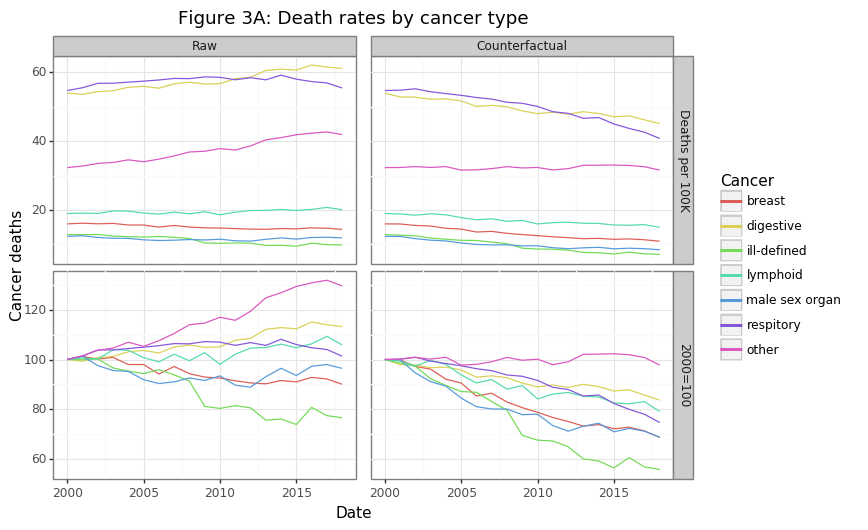

<ggplot: (8790153553245)>

In [185]:
plotnine.options.figure_size = (8, 5.5)
# 
di_msr = {'idx':'2000=100','rate':'Deaths per 100K'}
di_tt = {'counter':'Counterfactual', 'raw':'Raw'}
gg_cod = (ggplot(df_cod2_long, aes(x='years',y='value',color='cod2')) + 
          theme_bw() + geom_path() + 
          labs(x='Date',y='Cancer deaths') + 
          facet_grid('msr~tt',scales='free',labeller=labeller(msr=di_msr, tt=di_tt)) + 
          ggtitle('Figure 3A: Death rates by major cancer type') + 
          theme(subplots_adjust={'wspace': 0.05}) + 
          scale_color_discrete(name='Cancer'))
gg_cod

The majority of cancer deaths come from lung and gastrointestinal (digestive) cancers. Many GI cancers like pancreatic, gallbladder, or esophageal are notoriously difficult to treat. Overall the actual (raw) per capita death rates has been rising for some cancers and declining for others, as shown in the first column in Figure 3A. However, these rates may be rising for the same reason aggregate per capita death rates are increasing: an increasingly elderly population. The second column of the figure re-calculates these trends using the population-consistent approach discussed in section (2). After applying these adjustments the results are much more impressive: the major cancer categories have seen a decline in per capita mortality rates ranging from 15 to 40%. The one exception to this trend in the "other" category, which has shown no improvement, much like Dr. Raza's MDS and AML patients. It is worth looking into these categories.

/home/edrysdale/miniconda3/lib/python3.7/site-packages/plydata/cat_tools.py:1650: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


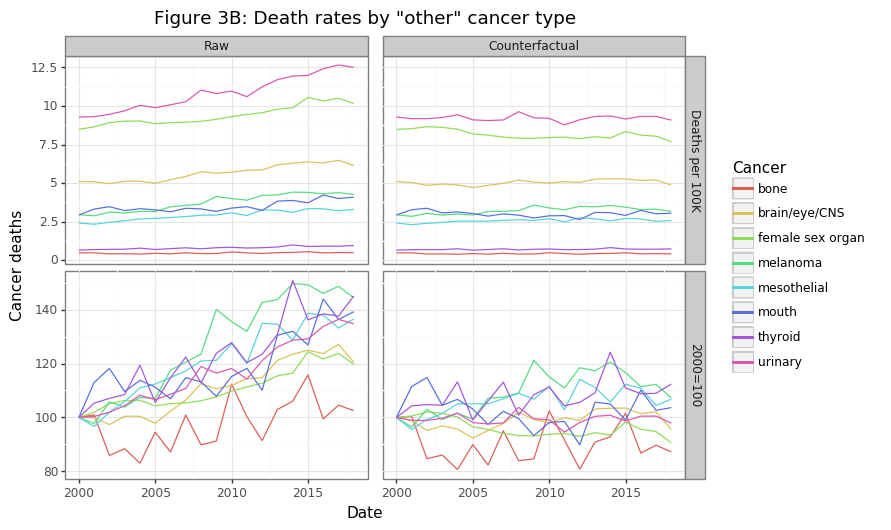

<ggplot: (8790158407193)>

In [195]:
tmp2 = df_alt_both.query('cod2=="other"').groupby(['years','cod','tt']).number.sum().reset_index()
df_cod = tmp2.merge(df_pop_total,'left','years').assign(rate=lambda x: x.number/(x.total/1e5))
df_cod = df_cod.sort_values(['tt','cod','years']).reset_index(None,True).drop(columns=['number','total'])
mi_yr = df_cod.years.min()
df_cod = df_cod.merge(df_cod.query('years==@mi_yr').drop(columns='years').rename(columns={'rate':'tmp'}),'left',['cod','tt'])
df_cod = df_cod.assign(idx=lambda x: x.rate/x.tmp*100).drop(columns='tmp')
df_cod_long = df_cod.melt(['tt','years','cod'],['rate','idx'],'msr')
df_cod_long = df_cod_long.assign(tt=lambda x: cat_rev(x.tt), msr=lambda x: cat_rev(x.msr))

gg_other = (ggplot(df_cod_long, aes(x='years',y='value',color='cod')) + 
          theme_bw() + geom_path() + 
          labs(x='Date',y='Cancer deaths') + 
          facet_grid('msr~tt',scales='free',labeller=labeller(msr=di_msr, tt=di_tt)) + 
          ggtitle('Figure 3B: Death rates by "other" cancer type') + 
          theme(subplots_adjust={'wspace': 0.05}) + 
          scale_color_discrete(name='Cancer'))
gg_other


Figure 3B shows the eight cancer types that were in the "other" category in Figure 3A. Though these cancer's have the lowest share of overall cancer deaths, combined, they call more Canadians every year save GI and lung cancers. The raw data shows rising per capita death rates, with the exception of bone cancers, which are largely unchanged. After applying population-structure adjustments, the counterfactual scenario shows no change in mortality rates for these cancers. When one considers the billions of dollars of research that have gone into many of these cancers, this is a sobering finding. 

## (4) Summary

The Canadian cancer data shows a bifurcation in treatment success.

THE LINEAR DECLINE IN CANCER DEATH RATES FOR THE BIG-6 SUGGESTS THAT THIS IS NOT AN IMMUNOTHERAPY REVOLUTION. NOR COULD IT BE GIVEN THAT MELANOMA IS NOT EVEN DECLINING!!

THE BURDEN OF CANCER WILL GROW AS WE BECOME AN OLDER SOCIETY. A STATISTICALLY FAIR ASSESSMENT SAYS THAT ONCOLOGY IS GETTING BETTER AND KEEPING MANY CANCER PATIENTS ALIVE, AND THE CANCERS WITH THE MOST SUCCESS KILL THE MOST NUMBER OF PEOPLE A YEAR. FROM A UTILITARIAN PERSPECTIVE THIS A GOOD THING. 

I WAS IMPRESSED BY THE QUALITY AND GRANULARITY OF THE CANADIAN DATA. 
